In [1]:
import pyreadstat
import numpy as np
import pandas as pd
import panel as pn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from matplotlib.font_manager import FontProperties
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.colors import Normalize
from dython.nominal import associations
import ppscore as pps
import warnings
warnings.simplefilter("ignore")
pn.extension('plotly', sizing_mode="stretch_width", raw_css=[open("styling.css").read()])
#pn.extension()

In [2]:
df, meta = pyreadstat.read_sav(
    'data.sav', encoding="ISO-8859-1", apply_value_formats=True)
df.drop([c for c in df.columns if any(c.startswith(x) for x in ['perception', 'gad', 'important', 'PHQ', 'IES'])], axis=1, inplace=True)
df.replace('', np.nan, inplace=True)
df.rename(columns={'classdepression21': 'depression_2021',
                   'classanxiety21': 'anxiety_2021',
                   'classptsd21': 'PTSD_2021',
                   'classedepression23': 'depression_2023',
                   "classeanxiety23": 'anxiety_2023',
                   "classeptsd23": "PTSD_2023",
                   'Interpretationdepression': 'interpretationdepression21',  # PHQ9 2021
                   'Interpretationanxiete': 'interpretationanxiete21',  # GAD7 2021
                   'Interpretationestpt': 'interpretationestptsd21',  # IES-R 2021
                   'interpretationphq': 'interpretationdepression23',  # PHQ9 2023
                   "interpretationgad": 'interpretationanxiete23',  # GAD7 2023
                   "inter1ies": 'interpretationestptsd23',  # IES-R 2023
                   'statutmartial': 'statut martial',  # Martial Status
                   'niveaudeducation': "niveau education",  # Educational level
                   'nombredepersonne': 'nb personnes',  # nb person
                   'zonedhabitat': "zone habitat",  # habitat zone
                   'niveausocioeconomique': 'niveau social',  # social level
                   'atcdssomatiques': 'atcds somatiques',  # history of illness
                   # history of personal psychiatric illness
                   'atcdspsychiatriquespersonnels': 'atcds psy personnels',
                   'datedelifectioncovid': "date covid infection",
                   'assistancerespiratoire': 'assistance respiratoire',  # respiratory assistance
                   'lieudisolement': "lieu isolement",  # quanrantine area
                   # work being infected
                   'avezvscontinuerdetravailleraveclinfectioncovid': "travail malgré infection covid",
                   'dureedarretdetravail': "duree arret travail",  # sick leave days
                   'utilisezvslesmesuresdhygieneetdeprotectiondanslaviequotidienne': "mesures hygiene quotidiennement",  # hygiene measures
                   'couvrezsystÃ©matiquementlabouche': 'bouche couvert systématiquement',  # mouth covered
                   # distancing measrues
                   'appliquezvslesreglesdedistanciationphysique': 'regles distanciation',
                   'avezvsreduitvoscontacts': 'contacts réduits',  # reduced contact
                   # Covid information source
                   'lasourcedinformationdurantlapandemie': "source information durant pandemie",
                   # increased workload
                   'avezvsconstatÃ©uneaugmentationdelachargedetravail': 'augmentation charge travail',
                   'avezvseubesoindunsoutienpsychologique': "besoin soutien psych",  # need of psy help
                   # need psy consult
                   'avezvseubesoinduneconsultationpsychiatrique': "besoin consultation psych",
                   # psy consulted since covid
                   'avezvsconsulteupsydepuisledebutdelepidemie': "psy consulté depuis debut epidemie",
                   'atcdsomatique': 'atcd somatique',  # history of illnesses
                   'numtel': 'num tel',  # number
                   'V1': 'Nom',  # name,
                   'Genre': 'gender',
                   'longcovidsym': 'long covid symptoms'}, inplace=True)
df['num tel'] = df['num tel'].apply(lambda x: np.nan if len(str(x)) < 8 or not x.isdigit() else x[:8].strip())
df["date covid infection"] = pd.to_datetime(df["date covid infection"])
df['age'] = df['age'].astype(np.int8)
df['duree arret travail'] = df['duree arret travail'].astype(np.float32)
df['nb personnes'] = df['nb personnes'].astype(np.int8)
df['duree arret travail'] = df['duree arret travail'].astype(np.float32)
df['habitat_b'] = df.habitat.replace(['en couple', 'avec ses parents'], 'en famille')

In [3]:
df.drop(['Nom', 'num tel'], axis=1, inplace=True)
df['tranche_age'] = pd.cut(df['age'].astype('int8'), bins=[18, 25, 35, 45, 55, 65, 75, 85])
df["date covid infection"] = df["date covid infection"].dt.to_period('M')

In [4]:
columns = ['depression_2023', 'anxiety_2023', 'PTSD_2023', 'gender', 'tranche_age','niveau social', 'niveau education', 'statut martial', 
           'long covid symptoms']
# Define the select widgets
select1 = pn.widgets.Select(name='X', options=columns, width=140, css_classes=['select-css'])
select2 = pn.widgets.Select(name='Y', options=columns, width=140, css_classes=['select-css'])
select3 = pn.widgets.Select(name='Z', options=columns, width=140, css_classes=['select-css'])
# Function to update the crosstab based on the selected columns
@pn.depends(select1.param.value, select2.param.value, select3.param.value)
def update_crosstab(selected_column1, selected_column2, selected_column3):
    cross_tab = pd.crosstab([df[selected_column1], df[selected_column2]], df[selected_column3],
                            margins=True, margins_name="Total", normalize='all').round(4)*100
    return cross_tab.style.format("{:.2f}%").background_gradient(cmap='cubehelix')#.set_table_styles([{'selector': 'th', 'props': [('background', '#222333'), ('color', 'white')]}])
# Create a Panel with the Select widgets and the crosstab
crosstab = pn.Column(pn.Row(select1, select2, select3, sizing_mode='fixed', align='center'), update_crosstab)
# Show the crosstab
#crosstab.servable()

In [197]:
cross_tab = pd.crosstab([df['depression_2023'].replace(['mild depression', 'minimal depression', 'severe depression'], [
                        'depression']*3), df['anxiety_2023']], df['PTSD_2023'], margins=True, margins_name="Total", normalize='all').round(4)*100
cross_tab.style.format("{:.2f}%").background_gradient(cmap='cubehelix')

In [8]:
def scatterplot(x, y, title, xlabel, ylabel, hue=None):
    # x and y must be numerical, hue must be categorical
    font = FontProperties(weight='bold')
    sns.set(context='paper', style="ticks", palette=sns.color_palette(
        "cubehelix", 8), color_codes=True)
    sns.lmplot(x=x, y=y, hue=hue, data=df, legend=False,
               scatter_kws={'s': 100, 'edgecolor': 'black'}, ci=None, height=8.5, aspect=1.5)
    plt.title(title, size=22, weight='bold', color='darkblue', loc='left')
    plt.xlabel(xlabel, size=18, weight='bold', color='darkblue')
    plt.ylabel(ylabel, size=18, weight='bold', color='darkblue')
    plt.xticks(fontproperties=font)
    plt.yticks(fontproperties=font)
    if hue:
        legend = plt.legend(title=hue, title_fontsize='13', fontsize='10', prop={
                            'weight': 'bold'}, shadow=True)
        plt.setp(legend.get_title(), weight='bold')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    return plt

In [149]:
columns_xy = ['age', 'interpretationdepression23', 'interpretationanxiete23', 'interpretationestptsd23']
columns_hue = [None, 'gender', 'habitat_b', 'besoin soutien psych']
# Define the select widgets
select1 = pn.widgets.Select(name='X', options=columns_xy, width=130, css_classes=['select-css'])
select2 = pn.widgets.Select(name='Y', options=columns_xy, width=130, css_classes=['select-css'])
select3 = pn.widgets.Select(name='hue', options=columns_hue, width=130, css_classes=['select-css'])
# Function to update the crosstab based on the selected columns
@pn.depends(select1.param.value, select2.param.value, select3.param.value)
def update_scatterplot(selected_column1, selected_column2, selected_column3, df=df):
    fig = px.scatter(df, x=selected_column1, y=selected_column2, color=selected_column3, trendline="ols", 
                     title=f'Scatterplot of {selected_column1} and {selected_column2}')#, color_discrete_sequence=px.colors.qualitative.Antique)
    fig.update_layout(autosize=False, width=480, height=230, template='presentation',paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)',
                      margin=dict(t=35, l=50, r=0, b=50),
                      title_font=dict(size=25, family='Rockwell', color='white'),
                      xaxis=dict(title_font=dict(size=20, family='Rockwell', color='white'), tickfont=dict(family='Rockwell', color='white', size=14)),
                      yaxis=dict(title_font=dict(size=20, family='Rockwell', color='white'), tickfont=dict(family='Rockwell', color='white', size=14)),
                      legend=dict(font=dict(family='Rockwell', color='white')))
    return pn.pane.Plotly(fig)
# Create a Panel with the Select widgets and the crosstab
scatter = pn.Column(pn.Row(select1, select2, select3, sizing_mode='fixed', align='center'), update_scatterplot)
# Show the Panel
#scatter.servable()

In [119]:
def barplot(x, y, title, xlabel, ylabel, hue=None):
    # at least one of x and y should be numeric, calculates the mean of y for each category in x
    font = FontProperties(weight='bold')
    plt.figure(figsize=(25, 8))
    sns.set(context='paper', style="ticks", palette=sns.color_palette(
        "cubehelix", 8), color_codes=True)
    sns.barplot(x=x, y=y, hue=hue, data=df, ci=None)
    plt.title(title, size=22, weight='bold', color='darkblue', loc='left')
    plt.xlabel(xlabel, size=18, weight='bold', color='darkblue')
    plt.ylabel(ylabel, size=18, weight='bold', color='darkblue')
    plt.xticks(fontproperties=font, fontsize=12)
    plt.yticks(fontproperties=font, fontsize=12)
    if hue != None:
        legend = plt.legend(title=hue, title_fontsize='13', fontsize='20', prop={
                            'weight': 'bold'}, shadow=True)
        plt.setp(legend.get_title(), weight='bold')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    return plt

In [10]:
columns_hue = [None, 'gender', 'habitat_b', 'besoin soutien psych']
columns_y = ['interpretationdepression23',
             'interpretationanxiete23', 'interpretationestptsd23']
# Define the select widgets
select1 = pn.widgets.Select(name='Y', options=columns_y, width=190)
select2 = pn.widgets.Select(name='hue', options=columns_hue, width=190)
# Function to update the crosstab based on the selected columns


@pn.depends(select1.param.value, select2.param.value)
def update_barplot(selected_column1, selected_column2):
    fig = px.histogram(df, x='long covid symptoms', y=selected_column1, color=selected_column2, pattern_shape='enfants', barmode='group', histfunc='avg',
                       title='PHQ9 and long covid symptoms barplot', labels={'longcovidsym': 'long covid symptoms', selected_column1: 'PHQ9 score'}, text_auto='.2f')
    fig.update_layout(autosize=False, width=1200, height=500, template='presentation',
                      title_font=dict(
                          size=24, family='Rockwell', color='darkblue'),
                      xaxis=dict(title_standoff=25, tickangle=5, tickfont=dict(
                          family='Rockwell', color='darkblue', size=14)),
                      yaxis=dict(title_standoff=25, tickfont=dict(
                          family='Rockwell', color='darkblue', size=14))
                      )
    fig.update_traces(textfont_size=13, textangle=0,
                      textposition="outside", cliponaxis=False)
    return pn.pane.Plotly(fig)


# Create a Panel with the Select widgets and the crosstab
panel = pn.Column(pn.Row(select1, select2, align='center'), update_barplot)
# Show the Panel
#panel.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'d2072050-2fd1-48e5-abce-66812edc9d7f': {'version…

In [12]:
def countplot(x, title, xlabel, hue=None):
    font = FontProperties(weight='bold')
    plt.figure(figsize=(25, 8))
    sns.set(context='paper', style="ticks", palette=sns.color_palette(
        "cubehelix", 8), color_codes=True)
    countplot = sns.countplot(x=x, hue=hue, data=df)
    plt.title(title, size=22, weight='bold', color='darkblue', loc='left')
    plt.xlabel(xlabel, size=18, weight='bold', color='darkblue')
    plt.ylabel('percentage', size=18, weight='bold', color='darkblue')
    plt.xticks(fontproperties=font, fontsize=18)
    plt.yticks(fontproperties=font, fontsize=18)
    if hue:
        legend = plt.legend(title=hue, title_fontsize='13', fontsize='20', prop={
                            'weight': 'bold'}, shadow=True)
        plt.setp(legend.get_title(), weight='bold')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    for p in countplot.patches:
        countplot.annotate('{:.1f}%'.format(100 * p.get_height()/len(df)), (p.get_x() + p.get_width() / 2., p.get_height()),
                           weight='bold', ha='center', va='center', xytext=(0, 10), textcoords='offset points', size=30)
    return plt

In [11]:
columns_hue = [None, 'gender', 'habitat_b', 'besoin soutien psych']
columns_x = ['depression_2023', 'anxiety_2023', 'PTSD_2023']
# Define the select widgets
select1 = pn.widgets.Select(name='X', options=columns_x, width=190)
select2 = pn.widgets.Select(name='hue', options=columns_hue, width=190)
# Function to update the crosstab based on the selected columns


@pn.depends(select1.param.value, select2.param.value)
def update_barplot(selected_column1, selected_column2):
    fig = px.histogram(df, x=selected_column1, color=selected_column2, pattern_shape='enfants', barmode='group', histfunc='count', histnorm='percent',
                       title='PHQ9 and long covid symptoms barplot', labels={'selected_column1': 'PHQ9 score'}, text_auto='.2f')
    fig.update_layout(autosize=False, width=1200, height=500, template='presentation',
                      title_font=dict(
                          size=24, family='Rockwell', color='darkblue'),
                      xaxis=dict(title_standoff=25, tickangle=5, tickfont=dict(
                          family='Rockwell', color='darkblue', size=14)),
                      yaxis=dict(title='Percent of PHQ9', title_standoff=25, tickfont=dict(
                          family='Rockwell', color='darkblue', size=14))
                      )
    fig.update_traces(textfont_size=13, textangle=0,
                      textposition="outside", cliponaxis=False)
    return pn.pane.Plotly(fig)


# Create a Panel with the Select widgets and the crosstab
panel = pn.Column(pn.Row(select1, select2, align='center'), update_barplot)
# Show the Panel
#panel.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'909f5480-a4e7-4383-8ad8-eeeeeac05e14': {'version…

In [14]:
def pieplot(x, title):
    sns.set(context='paper', style="ticks", palette=sns.color_palette(
        "cubehelix", 8), color_codes=True)
    fig, ax = plt.subplots(figsize=(25, 8))
    ax.pie(df[x].value_counts(), labels=df[x].value_counts().index, startangle=90, counterclock=False, explode=(0.03,)*df[x].nunique(),
           autopct='%1.1f%%', textprops={'size': 12, 'weight': 'bold', 'color': 'black'}, pctdistance=.78, rotatelabels=True)
    centre_circle = plt.Circle((0, 0), 0.9, fc='white')
    fig.gca().add_artist(centre_circle)
    ax.axis('equal')
    plt.text(0, 0, title, size=22, weight='bold',
             color='#444444', ha='center', va='center')
    plt.legend(df[x].value_counts().index, title="Categories", loc="upper left", shadow=True,
               bbox_to_anchor=(.6, 0, 0.5, 1), prop={'size': 10, 'weight': 'bold'}).get_title().set_fontsize(15)
    return plt

In [12]:
columns_x = ['depression_2023', 'anxiety_2023', 'PTSD_2023']
# Define the select widgets
select = pn.widgets.Select(name='X', options=columns_x, width=190)
# Function to update the crosstab based on the selected columns


@pn.depends(select.param.value)
def update_barplot(selected_column):
    fig = px.pie(df, names=selected_column)
    fig.update_layout(autosize=False, width=1200, height=500, template='presentation', legend=dict(x=.75),
                      title_font=dict(
                          size=24, family='Rockwell', color='darkblue'),
                      annotations=[dict(text='PHQ9', x=0.5, y=0.5, font_size=20, showarrow=False,
                                        font=dict(size=24, family='Rockwell', color='darkblue'))]

                      )
    fig.update_traces(textfont_size=15, hole=.86, marker=dict(
        line=dict(color='#000000', width=2)))
    return pn.pane.Plotly(fig)


# Create a Panel with the Select widgets and the crosstab
panel = pn.Column(pn.Row(select, align='center'), update_barplot)
# Show the Panel
#panel.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'25a61de5-5d1b-462b-96a9-a95aa3367315': {'version…

In [16]:
def mosaicplot(x, y, title):
    percentages = df.groupby([x, y]).size() / len(df) * 100
    def labelizer(k): return f'{percentages[k]:.1f}%'
    colors = plt.cm.get_cmap('Pastel2', len(percentages))
    norm = Normalize(vmin=percentages.min(), vmax=percentages.max())
    def properties(key): return {'color': colors(norm(percentages[key]))}
    mosaic(df, [x, y], label_rotation=45, gap=0.01,
           labelizer=labelizer, properties=properties)
    plt.gcf().set_size_inches(15, 5)
    plt.title(title, size=22, weight='bold', color='darkblue', loc='center')
    cax = plt.gcf().add_axes([.95, .1, .02, .8])
    plt.colorbar(plt.cm.ScalarMappable(cmap=colors, norm=norm),
                 cax=cax, label='Percentage')
    return plt

In [135]:
columns_xy = ['depression_2023', 'anxiety_2023', 'PTSD_2023', 'long covid symptoms']
# Define the select widgets
select1 = pn.widgets.Select(name='First Level', options=columns_xy, width=136, css_classes=['select-css'])
select2 = pn.widgets.Select(name='Second Level', options=columns_xy, width=136, css_classes=['select-css'])
# Function to update the crosstab based on the selected columns
@pn.depends(select1.param.value, select2.param.value)
def update_mosaic(selected_column1, selected_column2):
    if selected_column1 == selected_column2:
        fig = px.treemap(df.dropna(subset=[selected_column1, selected_column2]), path=[px.Constant("All Levels"), selected_column1], color=selected_column1,
                         hover_data=[selected_column1], color_discrete_sequence=px.colors.qualitative.Prism)
    else:
        fig = px.treemap(df.dropna(subset=[selected_column1, selected_column2]), path=[px.Constant("All Levels"), selected_column1, selected_column2], 
                         color=selected_column2, hover_data=[selected_column1, selected_column2], color_discrete_sequence=px.colors.qualitative.Antique)
    fig.update_layout(autosize=False, template='presentation', paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', height=525, width=275,
                      margin=dict(t=0, l=0, r=0, b=0))
    return pn.pane.Plotly(fig)

# Create a Panel with the Select widgets and the crosstab
treemap = pn.Column(pn.Row(select1, select2, sizing_mode='fixed', align='center'), update_mosaic)
#Show the Panel
#treemap.servable()

In [37]:
def histplot(x, threshold=None):
    # x and y must be numerical, hue must be categorical
    font = FontProperties(weight='bold')
    plt.figure(figsize=(25, 8))
    sns.histplot(x=x, data=df, stat="density", kde=True, color='darkblue', fill=True,
                 linewidth=4, bins=np.arange(df[x].min(), df[x].max()+1))
    if threshold:
        plt.axvline(threshold, color='r', linestyle='--', linewidth=4.5)
        plt.text(threshold + 0.1, plt.gca().get_ylim()
                 [1] * 0.8, f'Threshold: {threshold}', color='r', fontsize=14)
    plt.title(f'histogram of 2023 {x}', size=22,
              weight='bold', color='darkblue', loc='left')
    plt.xlabel(x, size=18, weight='bold', color='darkblue')
    plt.ylabel('density', size=18, weight='bold', color='darkblue')
    plt.xticks(fontproperties=font, fontsize=18)
    plt.yticks(fontproperties=font, fontsize=18)
    plt.margins(x=0)
    plt.grid(color='gray', linestyle='--', linewidth=1)
    return plt

In [14]:
columns_hue = [None, 'gender', 'habitat_b', 'besoin soutien psych']
columns_x = ['age', 'interpretationdepression23', 'interpretationanxiete23', 'interpretationestptsd23']
# Define the select widgets
select1 = pn.widgets.Select(name='X', options=columns_x, width=190)
select2 = pn.widgets.Select(name='hue_color', options=columns_hue, width=190)
select3 = pn.widgets.Select(name='hue_shape', options=columns_hue, width=190)
# Function to update the crosstab based on the selected columns
@pn.depends(select1.param.value, select2.param.value, select3.param.value)
def update_barplot(selected_column1, selected_column2, selected_column3):
    fig = px.histogram(df, x=selected_column1, color=selected_column2, pattern_shape=selected_column3, histnorm='probability', barmode='group',
                       nbins=int(np.ptp(df[selected_column1].dropna())), title='PHQ9 and long covid symptoms barplot', text_auto='.2f',
                       labels={selected_column1: 'PHQ9 score'})
    fig.update_layout(autosize=False, width=1200, height=500, template='presentation', bargap=0.1,
                      title_font=dict(size=24, family='Rockwell', color='darkblue'),
                      xaxis=dict(title_standoff = 25, tickfont=dict(family='Rockwell', color='darkblue', size=14)),
                      yaxis=dict(title_standoff = 25, tickfont=dict(family='Rockwell', color='darkblue', size=14))
)
    fig.update_traces(textfont_size=13, textangle=0, textposition="outside", cliponaxis=False)
    return pn.pane.Plotly(fig)
# Create a Panel with the Select widgets and the crosstab
panel = pn.Column(pn.Row(select1, select2, select3, align='center'), update_barplot)
# Show the Panel
#panel.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'d4dbfbfe-639c-4bfa-a1ac-a8d6afed17aa': {'version…

In [ ]:
columns_hue = [None, 'gender', 'habitat_b', 'besoin soutien psych']
columns_x = ['age', 'interpretationdepression23', 'interpretationanxiete23', 'interpretationestptsd23']
# Define the select widgets
select1 = pn.widgets.Select(name='X', options=columns_x, width=190)
select2 = pn.widgets.Select(name='hue', options=columns_hue, width=190)
# Function to update the crosstab based on the selected columns
@pn.depends(select1.param.value, select2.param.value)
def update_barplot(selected_column1, selected_column2):
    if selected_column2:
        categories = df[selected_column2].dropna().unique()
        fig = ff.create_distplot(hist_data=[df[df[selected_column2] == category][selected_column1].dropna() for category in categories], 
                                 group_labels=categories.tolist(), bin_size=1, show_rug=False, show_hist=False, colors=sns.color_palette("husl", 8))
    else:
        fig = ff.create_distplot(hist_data=[df[selected_column1]], group_labels=[selected_column1], bin_size=1, show_rug=False, show_hist=False, colors=sns.color_palette("husl"))
    fig.update_layout(autosize=False, width=1200, height=500, template='presentation', bargap=0.1, barmode='group',
                      title_font=dict(size=24, family='Rockwell', color='darkblue'),
                      xaxis=dict(title_standoff = 25, tickfont=dict(family='Rockwell', color='darkblue', size=14)),
                      yaxis=dict(title_standoff = 25, tickfont=dict(family='Rockwell', color='darkblue', size=14))
)
    fig.update_traces(textfont_size=13, cliponaxis=False)
    return pn.pane.Plotly(fig)
# Create a Panel with the Select widgets and the crosstab
panel = pn.Column(pn.Row(select1, select2, align='center'), update_barplot)
# Show the Panel
#panel.servable()

In [54]:
def violinplot(x, y, hue):
    font = FontProperties(weight='bold')
    plt.figure(figsize=(25, 8))
    sns.set(context='paper', style="ticks", palette=sns.color_palette(
        "cubehelix", 8), color_codes=True)
    sns.violinplot(data=df, x=x, y=y, hue=hue, split=True,
                   linewidth=4, fill=False, saturation=1, inner=None)
    sns.swarmplot(data=df, x=x, y=y, hue=hue, legend=False, size=12)
    plt.axhline(df[y].mean(), color='r', linestyle='--',
                linewidth=4.5, label=f'Mean: {df[y].mean():.2f}')
    plt.title(f'Violin plot of 2023 {y[14:-2]} and {x}',
              size=22, weight='bold', color='darkblue', loc='left')
    plt.xlabel(x, size=18, weight='bold', color='darkblue')
    plt.ylabel(f'{y[14:-2]} 2023', size=18, weight='bold', color='darkblue')
    plt.xticks(fontproperties=font, fontsize=18)
    plt.yticks(fontproperties=font, fontsize=18)
    legend = plt.legend(title=hue, title_fontsize='20',
                        fontsize='15', prop={'weight': 'bold'}, shadow=True)
    plt.setp(legend.get_title(), weight='bold')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    return plt

In [54]:
def kdeplot(x, hue, threshold=None):
    font = FontProperties(weight='bold')
    plt.figure(figsize=(25, 8))
    sns.set(context='paper', style="ticks", palette=sns.color_palette(
        "cubehelix", 8), color_codes=True)
    sns.kdeplot(data=df, x=x, hue=hue, fill=True, common_norm=False, alpha=.3)
    if threshold:
        plt.axvline(threshold, color='r', linestyle='--', linewidth=4.5)
        plt.text(threshold + 0.1, plt.gca().get_ylim()
                 [1] * 0.8, f'Threshold: {threshold}', color='r', fontsize=14)
    plt.title(f'density distribution of 2023 {x}', size=22,
              weight='bold', color='darkblue', loc='left')
    plt.xlabel(x, size=18, weight='bold', color='darkblue')
    plt.ylabel('Density', size=18, weight='bold', color='darkblue')
    plt.xticks(fontproperties=font, fontsize=18)
    plt.yticks(fontproperties=font, fontsize=18)
    # legend = plt.legend(title=hue, title_fontsize='20', fontsize='150', prop={'weight':'bold'}, shadow=True)
    # plt.setp(legend.get_title(), weight='bold')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    return plt

In [87]:
def boxplot(x, y, threshold, hue_swarm=None, hue_box=None):
    font = FontProperties(weight='bold')
    plt.figure(figsize=(25, 8))
    sns.set(context='paper', style="ticks", palette=sns.color_palette(
        "cubehelix", 8), color_codes=True)
    sns.boxplot(data=df, x=x, y=y, hue=hue_box, fill=False)
    sns.swarmplot(data=df, x=x, y=y, hue=hue_swarm, size=12)
    plt.axhline(threshold, color='r', linestyle='--',
                linewidth=4.5, label=f'threshold: {threshold}')
    plt.title(f'boxplot of 2023 {y[14:-2]} and {x}',
              size=22, weight='bold', color='darkblue', loc='left')
    plt.xlabel(x, size=18, weight='bold', color='darkblue')
    plt.ylabel(f'{y[14:-2]} 2023', size=18, weight='bold', color='darkblue')
    plt.xticks(fontproperties=font, fontsize=18)
    plt.yticks(fontproperties=font, fontsize=18)
    if hue_swarm:
        legend = plt.legend(title=hue_swarm, title_fontsize='20', fontsize='15', prop={
                            'weight': 'bold'}, shadow=True)
        plt.setp(legend.get_title(), weight='bold')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    return plt

FastGridTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [main-2202210205648] Column(sizing_mode='stretch_width')
        [0] Row(align='center', sizing_mode='fixed')
            [0] Select(css_classes=['select-css'], name='X', options=['age', 'interpretationdep...], value='age', width=130)
            [1] Select(css_classes=['select-css'], name='Y', options=['age', 'interpretationdep...], value='age', width=130)
            [2] Select(css_classes=['select-css'], name='hue', options=[None, 'gender', ...], width=130)
        [1] ParamFunction(function, _pane=Plotly, defer_load=False, sizing_mode='stretch_width')
    [main-2202210151824] Column(sizing_mode='stretch_both', styles={'background': 'green'})
    [main-2202184641680] Column(sizing_mode='stretch_width')
        [0] Row(align='center', sizing_mode='fixed')
            [0] Select(css_classes=['select-css'], name='First Level', options=['depression_2023', ...], value='depression_2023', width=136)
            [1] Select(css_classes=['select-css'], name='Second Level', options=['depression_2023', ...], value='depression_2023', width=136)
        [1] ParamFunction(function, _pane=Plotly, defer_load=False, sizing_mode='stretch_width')
    [main-2202008151504] Column(sizing_mode='stretch_width')
        [0] Row(align='center', sizing_mode='fixed')
            [0] Select(css_classes=['select-css'], name='X', options=['depression_2023', ...], value='depression_2023', width=140)
            [1] Select(css_classes=['select-css'], name='Y', options=['depression_2023', ...], value='depression_2023', width=140)
            [2] Select(css_classes=['select-css'], name='Z', options=['depression_2023', ...], value='depression_2023', width=140)
        [1] ParamFunction(function, _pane=DataFrame, defer_load=False, sizing_mode='stretch_width')
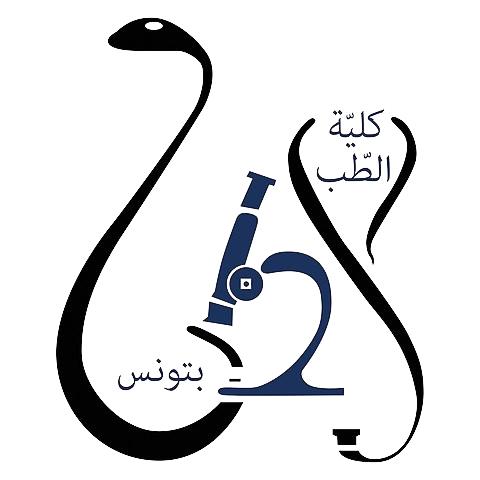

In [150]:
layout1 = pn.Column(styles={"background": "green"}, sizing_mode="stretch_both")
layout2 = pn.Column(styles={"background": "red"}, sizing_mode="stretch_both")
layout3 = pn.Column(styles={"background": "blue"}, sizing_mode="stretch_both")

template = pn.template.FastGridTemplate(site="Faculté de Médecine de Tunis", title="Covid 19 Mental health Statiscal Dashboard", prevent_collision=True, 
                                        logo = 'logo.png', theme=pn.template.DarkTheme)
template.main[0:2,0:5]=scatter
template.main[0:2,5:9]=layout1
template.main[0:4,9:12]=treemap
template.main[2:4,0:9]=crosstab
template.servable()

In [ ]:
# when studying correlation
df.drop(['interpretationdepression23', 'interpretationanxiete23', 'interpretationestptsd23',
         'interpretationdepression21', 'interpretationanxiete21', 'interpretationestptsd21', 'age'], axis=1, inplace=True)
df = df.astype('category')